# Advanced functionality


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from ipywidgets import interact

from reflectorch import *
from reflectorch.extensions.jupyter import JPlotLoss

torch.manual_seed(0); # set seed for reproducibility

## Using alternative parameterizations of the SLD profile

In this section we describe alternative parameterizations of the SLD profile implementated in `reflectorch` (i.e. other than the standard box model parameterization)

### Model with absorption

The default box model parameterization of the SLD profile presented in the previous sections takes into account only the real part of the SLD profile but neglects the imaginary part of the SLD which is related to the absorption of the scattering medium. While this is a reasonable approximation in many use cases, in `reflectorch` we are able to alter the parameterization of the SLD profile as to also incorporate the constant imaginary SLD value of each layer.

We can initialize a reflectorch model with absorption by making the following changes to the YAML configuration file:

 1. Firstly, we set the `model_name` argument of the prior sampler to `model_with_absorption` instead of `standard_model`. In addition, the parameter range and bound width range of the imaginary layer SLDs (`islds`) must be specified. If `constrained_isld` is set to `true`, the imaginary part of the SLD is constrained to not exceed a predefined fraction `max_sld_share` of the real part of the SLD (**Note**: `constrained_roughness` must also be `true`).

```{code-block} yaml
:emphasize-lines: 10,15,16,19,21

dset:
  cls: ReflectivityDataLoader
  prior_sampler:
    cls: SubpriorParametricSampler
    kwargs:
      param_ranges:
        thicknesses: [1., 500.]
        roughnesses: [0., 60.]
        slds: [0., 150.]
        islds: [0., 30.]
      bound_width_ranges:
        thicknesses: [1.0e-2, 500.]
        roughnesses: [1.0e-2, 60.]
        slds: [ 1.0e-2, 5.]
        islds: [1.0e-2, 5.]
      model_name: model_with_absorption
      max_num_layers: 2
      constrained_roughness: true
      constrained_isld: true
      max_thickness_share: 0.5
      max_sld_share: 0.2
      logdist: false
      scale_params_by_ranges: false
      scaled_range: [-1., 1.]
      device: 'cuda'
```

2. For the 2-layer box model parameterization of the SLD profile without absorption, the neural network had to predict 8 values (2 thicknesses, 3 roughnesses, 3 real layer SLDs). When absorption is considered, we have 3 additional output values (the imaginary layer SLDs), summing up to a total of 11. The computation for a higher number of layers is analogous. Thus the neural network architecture must also reflect these changes in the input and output dimensionalities: in this example the `dim_out` argument is set to 11.

```{code-block} yaml
:emphasize-lines: 17

model:
  network:
    cls: NetworkWithPriors
    pretrained_name: null
    device: 'cuda'
    kwargs:
      embedding_net_type: 'conv'
      embedding_net_kwargs:
        in_channels: 1
        hidden_channels: [32, 64, 128, 256, 512]
        kernel_size: 3
        dim_embedding: 128
        dim_avpool: 1
        use_batch_norm: true
        activation: 'gelu'
      pretrained_embedding_net: null
      dim_out: 11
      dim_conditioning_params: 0
      layer_width: 512
      num_blocks: 6
      repeats_per_block: 2
      residual: true
      use_batch_norm: true
      use_layer_norm: false
      mlp_activation: 'gelu'
      conditioning: 'concat'
```

We initialize a model with absorption from a suitable configuration file.

In [2]:
trainer = get_trainer_by_name(config_name='a_base_point_xray_conv_absorption', load_weights=False)

Model a_base_point_xray_conv_absorption loaded. Number of parameters: 3.84 M


We observe that the parametric model is `ModelWithAbsorption` and the sampler strategy is `ConstrainedRoughnessAndImgSldSamplerStrategy`

In [3]:
trainer.loader.prior_sampler.model_name, trainer.loader.prior_sampler.param_model, trainer.loader.prior_sampler.param_model.sampler_strategy

('model_with_absorption',
 <reflectorch.data_generation.priors.sampler_strategies.ConstrainedRoughnessAndImgSldSamplerStrategy at 0x7f8eae29f340>)

In [4]:
batch_size = 64
simulated_data = trainer.loader.get_batch(batch_size)

n_layers = simulated_data['params'].max_layer_num
n_params = simulated_data['params'].num_params

print(f'Number of layers: {n_layers},  Number of film parameters: {n_params}')
print('SLD data type: ' + str(simulated_data['params'].slds.dtype))
print('Img slds properly constrained with respect to real slds: ' + str(torch._is_all_true(simulated_data['params'].slds.imag < 0.2*simulated_data['params'].slds.real).item()))

Number of layers: 2,  Number of film parameters: 11
SLD data type: torch.complex128
Img slds properly constrained with respect to real slds: True


We observe that the `slds` tensor is of complex type now. The absorption leads to the rounding of the total reflection edge and the smoothing-off of oscillations of the reflectivity curve.

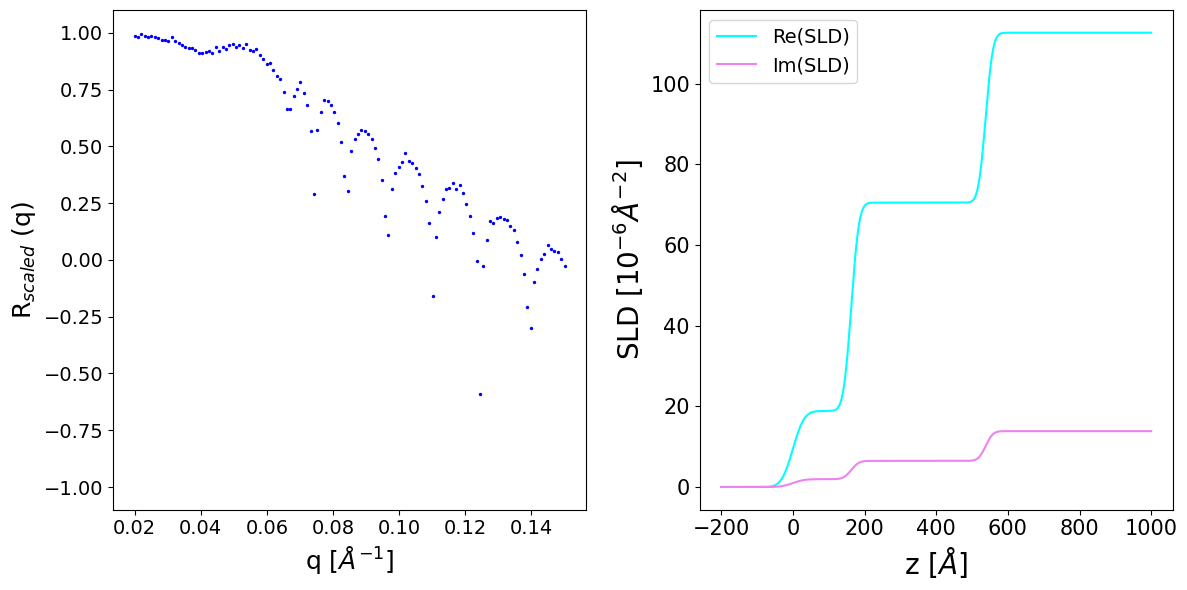

In [5]:
q = to_np(simulated_data['q_values'])[0]
scaled_noisy_curves = simulated_data['scaled_noisy_curves']

fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].set_ylim(-1.1, 1.1)
ax[0].set_xlabel('q [$Å^{-1}$]', fontsize=18)
ax[0].set_ylabel('R$_{scaled}$ (q)', fontsize=18)
ax[0].tick_params(axis='both', which='major', labelsize=14)

i = 0
ax[0].scatter(q, to_np(scaled_noisy_curves[i]), c='blue', s=2.0);

z_axis = torch.linspace(-200, 1000, 1000, device='cuda')
_, sld_profile_real, _ = get_density_profiles(
    simulated_data['params'].thicknesses, 
    simulated_data['params'].roughnesses,
    simulated_data['params'].slds.real,
    z_axis=z_axis)
_, sld_profile_imag, _ = get_density_profiles(
    simulated_data['params'].thicknesses, 
    simulated_data['params'].roughnesses,
    simulated_data['params'].slds.imag,
    z_axis=z_axis)

ax[1].plot(to_np(z_axis), to_np(sld_profile_real[i]), c='cyan', label='Re(SLD)')
ax[1].plot(to_np(z_axis), to_np(sld_profile_imag[i]), c='violet', label='Im(SLD)')
ax[1].set_xlabel('z [$Å$]', fontsize=20)
ax[1].set_ylabel('SLD [$10^{-6} Å^{-2}$]', fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='minor', labelsize=15)
ax[1].legend(fontsize=14)

plt.tight_layout()

### Periodically repeating monolayer

This SLD parameterization addresses the following commonly encountered scenario for thin films. On top of a silicon/silicon oxide substrate we consider a thin film composed of repeating identical monolayers (grey curve in the figure), each monolayer consisting of two boxes with distinct SLDs. A sigmoid envelope modulating the SLD profile of the monolayers defines the film thickness and the roughness at the top interface (green curve in the figure). A second sigmoid envelope can be used to modulate the amplitude of the monolayer SLDs as a function of the displacement from the position
of the first sigmoid (red curve in the figure). These two sigmoids allow one to model a thin film that is coherently ordered up to a certain coherent thickness and gets incoherently ordered or amorphous toward the top of the film. In addition, a layer between the substrate and the multilayer (i.e. ”phase layer”) is introduced to account for the interface structure, which does not necessarily have to be identical to the multilayer period.

```{figure} sketch_multilayer_0.png
:scale: 50
:align: center
:name: figure_multilayer
SLD parameterization of a multilayer consisting of periodically repeating monolayers
```

This parameterization is described by 17 film parameters, their physical description together with their corresponding alias in the YAML configuration file being shown in the following table:

| **Parameter description** | **Parameter alias in the configuration file** |
|---------------|---------------------|
| monolayer thickness (i.e. two boxes stacked together) | d_block |
| relative roughness of the monolayer interfaces (wrt. the monolayer thickness) | s_block_rel |
| SLD of the first box in the monolayer | r_block |
| SLD difference between the second and the first box in the monolayer | dr |
| fraction of the monolayer thickness belonging to the first box | d_block1_rel |
| roughness of the silicon substrate | s_si |
| SLD of the silicon substrate | r_si |
| thickness of the silicon oxide layer | d_sio2 |
| roughness of the silicon oxide layer | s_sio2 |
| SLD of the silicon oxide layer | r_sio2 |
| SLD of the phase layer | r3 |
| relative thickness of the phase layer (wrt. the monolayer thickness) | d3_rel |
| relative roughness of the phase layer (wrt. the monolayer thickness) | s3_rel |
| relative position of the first sigmoid (i.e. total film thickness) | d_full_rel |
| relative width of the first sigmoid | rel_sigmas |
| relative position of the second sigmoid (coherently ordered film thickness) | dr_sigmoid_rel_pos |
| relative width of the second sigmoid | dr_sigmoid_rel_width |

We can initialize a reflectorch model which uses this type of SLD parameterization by making the following changes to the YAML configuration file:

 1. Firstly, we set the `model_name` argument of the prior sampler to `repeating_multilayer_v3` instead of `standard_model`, and the `max_num_layers` argument to a high value representing the maximum considered number of monolayers (e.g. 30). In addition, the parameter ranges and bound width ranges for the 17 multilayer parameters must be specified (the above table shows the correspondance between the physical parameters and their YAML subkeys in the configuration file). 

```{code-block} yaml
:emphasize-lines: 41, 42

dset:
  prior_sampler:
    cls: SubpriorParametricSampler
    kwargs:
      param_ranges:
          d_full_rel: [0, 25]
          rel_sigmas: [0, 5]
          dr_sigmoid_rel_pos: [-10, 10]
          dr_sigmoid_rel_width: [0, 20]
          d_block1_rel: [0.01, 0.99]
          d_block: [10, 20]
          s_block_rel: [0., 0.3]
          r_block: [0., 20.] 
          dr: [-10., 10.]
          d3_rel: [0, 1] 
          s3_rel: [0, 1] 
          r3: [0., 25] 
          d_sio2: [0, 10] 
          s_sio2: [0, 10] 
          s_si: [0., 10] 
          r_sio2: [17., 19.]
          r_si: [19., 21.]
      bound_width_ranges:
          d_full_rel: [0.1, 25]
          rel_sigmas: [0.1, 5]
          dr_sigmoid_rel_pos: [0.1, 20]
          dr_sigmoid_rel_width: [0.1, 20]
          d_block1_rel: [0.01, 1.0]
          d_block: [0.1, 10.]
          s_block_rel: [0.1, 0.3]
          r_block: [0.1, 5.]
          dr: [0.1, 5.]
          d3_rel: [0.01, 1]
          s3_rel: [0.01, 1]
          r3: [0.01, 25]
          d_sio2: [0.01, 10]
          s_sio2: [0.01, 10]
          s_si: [0.01, 10]
          r_sio2: [0.01, 2]
          r_si: [0.01, 2]
      model_name: repeating_multilayer_v3
      max_num_layers: 30
      logdist: false
      scale_params_by_ranges: false
      scaled_range: [-1., 1.]
      device: 'cuda'
```

2. The neural network architecture must be set up such that the `dim_out` argument (i.e. the output dimension) is set to the number of predicted parameters which in this case is 17.

```{code-block} yaml
:emphasize-lines: 13

model:
  network:
    cls: NetworkWithPriors
    pretrained_name: null
    device: 'cuda'
    kwargs:
      embedding_net_type: 'conv'
      embedding_net_kwargs:
        in_channels: 1
        hidden_channels: [32, 64, 128, 256, 512]
        dim_embedding: 128
        dim_avpool: 1
        activation: 'gelu'
        use_batch_norm: true
      pretrained_embedding_net: null
      dim_out: 17
      layer_width: 512
      num_blocks: 6
      repeats_per_block: 2
      mlp_activation: 'gelu'
      dropout_rate: 0.0
      conditioning: 'concat'
```

<!-- ```{figure} fig_reflectometry_embedding_networks.png
:scale: 25 %
:align: center
:name: embedding_networks
Embedding Networks
``` -->

#### Training

We initialize a model from a suitable configuration file. Here we use an extended q range, up to 0.5 Å$^{-1}$.

In [3]:
trainer = get_trainer_by_name(config_name='c_repeating_multilayer', load_weights=False)

Model c_repeating_multilayer loaded. Number of parameters: 3.85 M


In [7]:
simulated_data = trainer.loader.get_batch(batch_size=64)

n_layers = simulated_data['params'].max_layer_num
n_params = simulated_data['params'].num_params

print(f'Max number of layers: {n_layers},  Number of film parameters: {n_params}')

Max number of layers: 30,  Number of film parameters: 17


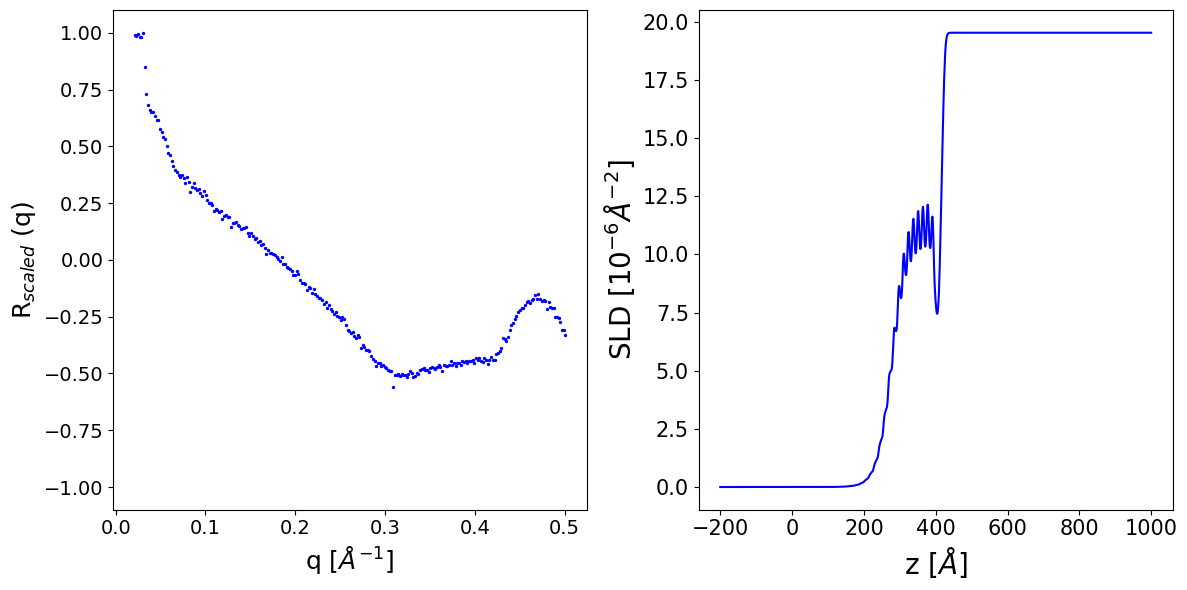

In [8]:
q = to_np(simulated_data['q_values'])[0]
scaled_noisy_curves = simulated_data['scaled_noisy_curves']

i = 3

fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].set_ylim(-1.1, 1.1)
ax[0].set_xlabel('q [$Å^{-1}$]', fontsize=18)
ax[0].set_ylabel('R$_{scaled}$ (q)', fontsize=18)
ax[0].tick_params(axis='both', which='major', labelsize=14)
    
ax[0].scatter(q, to_np(scaled_noisy_curves[i]), c='blue', s=2.0);

z_axis = torch.linspace(-200, 1000, 1000, device='cuda')
_, sld_profile, _ = get_density_profiles(
    simulated_data['params'].thicknesses, 
    simulated_data['params'].roughnesses,
    simulated_data['params'].slds,
    z_axis=z_axis)
    
ax[1].plot(z_axis.cpu().numpy(), to_np(sld_profile[i]), c='b', label='ground truth')

ax[1].set_xlabel('z [$Å$]', fontsize=20)
ax[1].set_ylabel('SLD [$10^{-6} Å^{-2}$]', fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='minor', labelsize=15)

plt.tight_layout()

#### Inference

In [9]:
inference_model = EasyInferenceModel(config_name='c_repeating_multilayer_trained1', device='cpu')

Configuration file `D:\Github Projects\reflectorch\reflectorch\configs\c_repeating_multilayer_trained1.yaml` found locally.
Weights file `D:\Github Projects\reflectorch\reflectorch\saved_models\model_c_repeating_multilayer_trained1.safetensors` found locally.
Model c_repeating_multilayer_trained1 loaded. Number of parameters: 3.85 M
The model corresponds to a `repeating_multilayer_v3` parameterization with 30 layers (17 predicted parameters)
Parameter types and total ranges:
- d_full_rel: [0, 25]
- rel_sigmas: [0, 5]
- dr_sigmoid_rel_pos: [-10, 10]
- dr_sigmoid_rel_width: [0, 20]
- d_block1_rel: [0.01, 0.99]
- d_block: [10, 20]
- s_block_rel: [0.0, 0.3]
- r_block: [0.0, 20.0]
- dr: [-10.0, 10.0]
- d3_rel: [0, 1]
- s3_rel: [0, 1]
- r3: [0.0, 25]
- d_sio2: [0, 10]
- s_sio2: [0, 10]
- s_si: [0.0, 10]
- r_sio2: [17.0, 19.0]
- r_si: [19.0, 21.0]
Allowed widths of the prior bound intervals (max-min):
- d_full_rel: [0.1, 25]
- rel_sigmas: [0.1, 5]
- dr_sigmoid_rel_pos: [0.1, 20]
- dr_sigmoid_

We load an experimental curve and make a prediction:

d_full_rel           : 12.20
rel_sigmas           : 1.75
dr_sigmoid_rel_pos   : -2.32
dr_sigmoid_rel_width : 16.05
d_block1_rel         : 0.74
d_block              : 16.80
s_block_rel          : 0.06
r_block              : 14.76
dr                   : -8.55
d3_rel               : 0.18
s3_rel               : 0.41
r3                   : 9.58
d_sio2               : 7.33
s_sio2               : 1.83
s_si                 : 4.82
r_sio2               : 17.52
r_si                 : 20.19


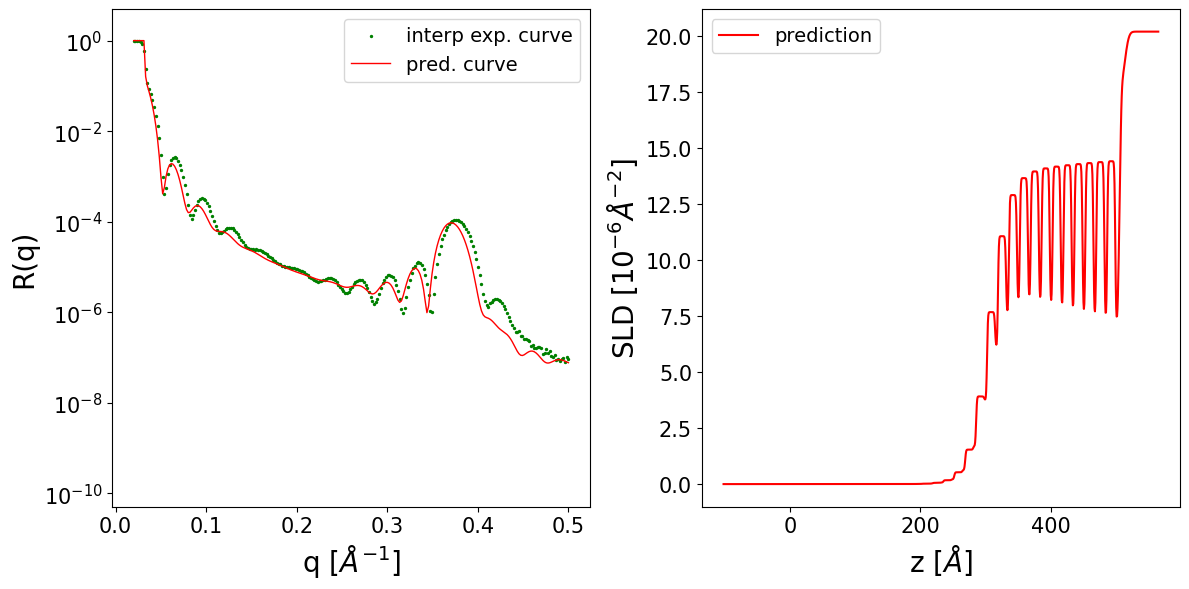

In [11]:
multilayer_data_path = '.././exp_data/DIP-nSi_34a.dat'

data = np.genfromtxt(multilayer_data_path, delimiter='\t', skip_header=0, unpack=True)
q_vals = data[0]
intensity_vals = data[1] 

interp_range = [0.02, 0.5]
interp_points = 256
q_interp = np.linspace(interp_range[0], interp_range[1], interp_points)

min_q_idx = abs(q_vals - interp_range[0]).argmin()
max_q_idx = abs(q_vals - interp_range[1]).argmin() + 1
q = q_vals[min_q_idx:max_q_idx]
curve = intensity_vals[min_q_idx:max_q_idx]
exp_curve_interp = interp_reflectivity(q_interp, q, curve)

q_model = inference_model.trainer.loader.q_generator.q.cpu().numpy()

prior_bounds = [
    (5., 20.), #relative sigmoid center
    (0., 5.), #relative roughness
    (-10., 10.), #position of the second sigmoid relative to d_full_rel (units are d_block)
    (0., 20.), #width of the second sigmoid relative to d_full_rel (units are d_block)
    (0.6, 0.9), #fractional thickness of one box1 in the monolayer
    (16., 17.5), #thickness of one monolayer (two boxes stacked together)
    (0.05, 0.3), #roughness of each interface in the monolayer relative to d_block
    (5., 20.), ##SLD of box1 in the multilayer
    (-10, -5), #dr = SLD(box2) - SLD(box1)
    (0, 1), #relative thickness of phase layer with respect to d_block
    (0, 1), #relative roughness of phase layer with respect to d_block
    (5, 15), #SLD of phase layer
    (5, 10), #thickness SiO2
    (0, 10), #roughness SiO2
    (0, 10), #roughness Si
    (17., 18.), #SLD SiO2
    (19.5, 20.5), #SLD Si
]

prediction_dict = inference_model.predict(reflectivity_curve=exp_curve_interp,
                                          q_values=q_model,
                                          prior_bounds=prior_bounds,
                                          clip_prediction=False,
                                          calc_pred_curve=True,
                                          calc_pred_sld_profile=True,
                                          )


pred_params = prediction_dict['predicted_params_array']
pred_curve = prediction_dict['predicted_curve']

pred_sld_xaxis = prediction_dict['predicted_sld_xaxis']
pred_sld_profile = prediction_dict['predicted_sld_profile']

n_layers = inference_model.trainer.loader.prior_sampler.max_num_layers
for param_name, param_val in zip(prediction_dict["param_names"], pred_params):
        print(f'{param_name.ljust(20)} : {param_val:.2f}')

fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].set_yscale('log')
ax[0].set_ylim(0.5e-10, 5)
ax[0].set_xlabel('q [$Å^{-1}$]', fontsize=20)
ax[0].set_ylabel('R(q)', fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[0].tick_params(axis='both', which='minor', labelsize=15)
y_tick_locations = [10**(-2*i) for i in range(6)]
ax[0].yaxis.set_major_locator(plt.FixedLocator(y_tick_locations))
    
ax[0].scatter(q_model, exp_curve_interp, c='g', s=2, label='interp exp. curve')
ax[0].plot(q_model, pred_curve, c='r', lw=1, label='pred. curve')

ax[0].legend(loc='upper right', fontsize=14);

ax[1].plot(pred_sld_xaxis, pred_sld_profile, c='r', label='prediction')
ax[1].set_xlabel('z [$Å$]', fontsize=20)
ax[1].set_ylabel('SLD [$10^{-6} Å^{-2}$]', fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='minor', labelsize=15)
ax[1].legend(fontsize=14);

plt.tight_layout()

In [11]:
prediction_dict.keys()

dict_keys(['predicted_params_object', 'predicted_params_array', 'param_names', 'predicted_curve', 'predicted_sld_profile', 'predicted_sld_xaxis'])

### Parameterizations with nuisance parameters (experimental imperfections)

To account for experimental imperfections in reflectometry measurements, any of the parameterizations in reflectorch can be extended to include nuisance parameters. These parameters model common experimental artifacts that affect the measured reflectivity curve:

- `r_scale`: A multiplicative scaling factor for the reflectivity, accounting for imperfect intensity normalization.

- `q_shift`: A shift in the momentum transfer vector q, modeling misalignment or sample positioning errors.

- `log10_background`: A constant background term (here defined in log space), often seen in neutron reflectometry experiments.

These nuisance parameters can be incorporated into the prior sampling configuration, as shown below. Each parameter can be individually enabled or disabled via the `shift_param_config` dictionary. When enabling additional parameters:
- ensure the neural network’s output dimension (`dim_out`) matches the total number of predicted parameters (parameters of the base parameterization + nuisance parameters)

- when performing inference, the list of prior bounds must include any enabled nuisance parameters in the correct order

```{code-block} yaml
:emphasize-lines: 10, 11, 12, 17, 18, 19, 20, 21, 22, 23

dset:
  cls: ReflectivityDataLoader
  prior_sampler:
    cls: SubpriorParametricSampler
    kwargs:
      param_ranges:
        thicknesses: [1., 1500.]
        roughnesses: [0., 60.]
        slds: [-8., 16.]
        q_shift: [-0.002, 0.002]
        r_scale: [0.9, 1.1]
        log10_background: [-10.0, -4.0]
      bound_width_ranges:
        thicknesses: [1.0e-2, 1500.]
        roughnesses: [1.0e-2, 60.]
        slds: [1.0e-2, 5.]
        q_shift: [1.0e-2, 0.004]
        r_scale: [1.0e-2, 0.2]
        log10_background: [1.0e-2, 6.0]
      shift_param_config:
        q_shift: false
        r_scale: true
        log10_background: true
      model_name: standard_model
      max_num_layers: 1
      constrained_roughness: true
      max_thickness_share: 0.5
      logdist: false
      scale_params_by_ranges: false
      scaled_range: [-1., 1.]
      device: 'cuda'
```

## Using alternative embedding networks

### Training

Embedding networks have the role of processing the reflectivity curves, producing a latent representation which is fed together with the prior bounds to the main fully-connected (MLP) network in order to obtain the predictions. The default embedding network is the 1D CNN, whose arguments have been already explained in the previous section.

```{figure} fig_reflectometry_embedding_networks.png
:scale: 25
:align: center
:name: figure_embedding_networks
Embedding networks: (a) CNN (b) FNO
```

Alternatively, we can use an embedding network inspired by the Fourier Neural Operator (FNO) architecture. In this scenario the reflectivity curves together with their respective q-values are input to the embedding network. It allows us to train the model on reflectivity curves with variable discretizations (variable q ranges and numbers of points in the curves).

We can initialize a reflectorch model which uses the FNO-based embedding network by making the following changes to the YAML configuration file:

 1. Firstly, the `q_generator` has to be changed to `VariableQ`. Its arguments are:
 - `q_min_range` - the range for sampling the minimum q value of the curves, *q_min*
 - `q_max_range` - the range for sampling the maximum q value of the curves, *q_max*
 - `n_q_range` - the range for the number of points in the curves (equidistantly sampled between *q_min* and *q_max*, the number of points varies between batches but is constant within a batch)

```{code-block} yaml
:emphasize-lines: 3, 5, 6, 7
dset:     
  q_generator:
    cls: VariableQ
    kwargs:
      q_min_range: [0.01, 0.03]
      q_max_range: [0.15, 0.4]
      n_q_range: [128, 256]
      device: 'cuda'
```

 2. We can change the embedding network while keeping the architecture of the MLP intact. The `embedding_net_type` keyword argument of the network will be `fno`. We also have to provide the arguments for this specific embedding network, which in this case are:
- `in_channels` - the number of input channels to the FNO-based embedding network  (should be 2, i.e. (R(q), q))
- `dim_embedding` - the dimension of the embedding produced by the FNO
- `width_fno` - the number of channels in the FNO blocks
- `n_fno_blocks`- the number of FNO blocks
- `modes` - the number of Fourier modes that are utilized
- `activation` - the type of activation function in the embedding network
- `fusion_self_attention` - if `True` a fusion layer is used after the FNO blocks to produce the final output
- `fsa_activation` - the type of activation function in fusion self attention layer


```{code-block} yaml
:emphasize-lines: 7, 8

model:
  network:
    cls: NetworkWithPriors
    pretrained_name: null
    device: 'cuda'
    kwargs:
      embedding_net_type: 'fno'
      embedding_net_kwargs:
        in_channels: 2
        dim_embedding: 128
        width_fno: 128
        n_fno_blocks : 4
        modes: 16
        activation: 'gelu'
        fusion_self_attention: true
        fsa_activation: 'gelu'
```

3. The `train_with_q_input` argument of `trainer_kwargs` must be set to `True`.

```{code-block} yaml
:emphasize-lines: 11

training:
  trainer_cls: PointEstimatorTrainer
  num_iterations: 10000
  batch_size: 4096
  lr: 1.0e-3
  grad_accumulation_steps: 1
  clip_grad_norm_max: 1.0
  update_tqdm_freq: 1
  optimizer: AdamW
  trainer_kwargs:
    train_with_q_input: true
```

### Inference

We perform inference on the two curves previously shown in the *Using reflectorch* tutorial:

In [12]:
inference_model = EasyInferenceModel(config_name='mc-o4', device='cpu')

Configuration file `D:\Github Projects\reflectorch\reflectorch\configs\mc-o4.yaml` found locally.
Weights file `D:\Github Projects\reflectorch\reflectorch\saved_models\model_mc-o4.safetensors` found locally.
Model mc-o4 loaded. Number of parameters: 14.61 M
The model corresponds to a `standard_model` parameterization with 2 layers (8 predicted parameters)
Parameter types and total ranges:
- thicknesses: [0.0, 500.0]
- roughnesses: [0.0, 20.0]
- slds: [0.0, 50.0]
Allowed widths of the prior bound intervals (max-min):
- thicknesses: [0.01, 500.0]
- roughnesses: [0.01, 20.0]
- slds: [0.01, 5.0]
The model was trained on curves discretized at a number between 128 and 256 of uniform points between q_min in [0.01, 0.05] and q_max in [0.15, 0.4]
The following quantities are additional inputs to the network: prior bounds, q values.


In [13]:
data = np.loadtxt('../exp_data/data_PTCDI-C3.txt', delimiter='\t', skiprows=1)
q_exp = data[..., 0]
curve_exp = data[..., 1]

print(curve_exp.shape, q_exp.shape, q_exp.min(), q_exp.max())

prior_bounds = [(1., 400.), (1., 10.), #layer thicknesses (top to bottom)
                (0., 20.), (0., 15.), (0., 15.), #interlayer roughnesses (top to bottom)
                (10., 13.), (20.,21.), (20., 21.)] #real layer slds (top to bottom)

prediction_dict = inference_model.predict(reflectivity_curve=curve_exp,
                                          q_values=q_exp,
                                          prior_bounds=prior_bounds,
                                          clip_prediction=False,
                                          polish_prediction=False,
                                          calc_pred_curve=True,
                                          )

pred_params = prediction_dict['predicted_params_array']
pred_curve = prediction_dict['predicted_curve']

(141,) (141,) 0.0142368058 0.213456644


Thickness L2   : 186.60
Thickness L1   : 8.87
Roughness L2   : 19.92
Roughness L1   : 3.64
Roughness sub  : 5.71
SLD L2         : 11.17
SLD L1         : 20.33
SLD sub        : 20.53


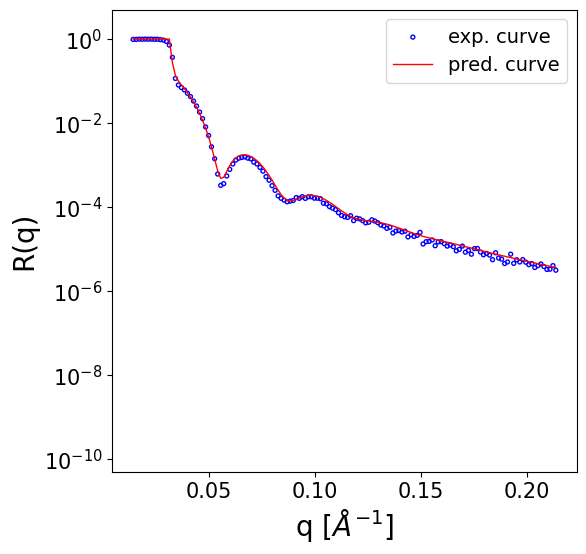

In [14]:
n_layers = inference_model.trainer.loader.prior_sampler.max_num_layers
for param_name, param_val in zip(prediction_dict["param_names"], pred_params):
        print(f'{param_name.ljust(14)} : {param_val:.2f}')

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.set_yscale('log')
ax.set_ylim(0.5e-10, 5)
ax.set_xlabel('q [$Å^{-1}$]', fontsize=20)
ax.set_ylabel('R(q)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
y_tick_locations = [10**(-2*i) for i in range(6)]
ax.yaxis.set_major_locator(plt.FixedLocator(y_tick_locations))
    
ax.scatter(q_exp, curve_exp, facecolors='none', edgecolors='blue', s=8, label='exp. curve')
#ax.scatter(q_exp, curve_exp, c='b', s=2, label='exp. curve')
ax.plot(q_exp, pred_curve, c='r', lw=1, label='pred. curve')
#ax.plot(q_exp, prediction_dict['polished_curve'], c='orange', lw=1, label='polished pred. curve')

ax.legend(loc='upper right', fontsize=14);

In [15]:
data = np.loadtxt('../exp_data/data_C60.txt', delimiter='\t', skiprows=1)
q_exp = data[..., 0]
curve_exp = data[..., 1]

print(curve_exp.shape, q_exp.shape, q_exp.min(), q_exp.max())

prior_bounds = [(1., 400.), (1., 10.), #layer thicknesses (top to bottom)
                (0., 20.), (0., 15.), (0., 15.), #interlayer roughnesses (top to bottom)
                (13., 18.), (20.,21.), (20., 21.)] #real layer slds (top to bottom)

prediction_dict = inference_model.predict(reflectivity_curve=curve_exp,
                                          q_values=q_exp,
                                          prior_bounds=prior_bounds,
                                          clip_prediction=False,
                                          polish_prediction=True,
                                          calc_pred_curve=True,
                                          )


pred_params = prediction_dict['predicted_params_array']
pred_curve = prediction_dict['predicted_curve']

(91,) (91,) 0.0142368058 0.142432068


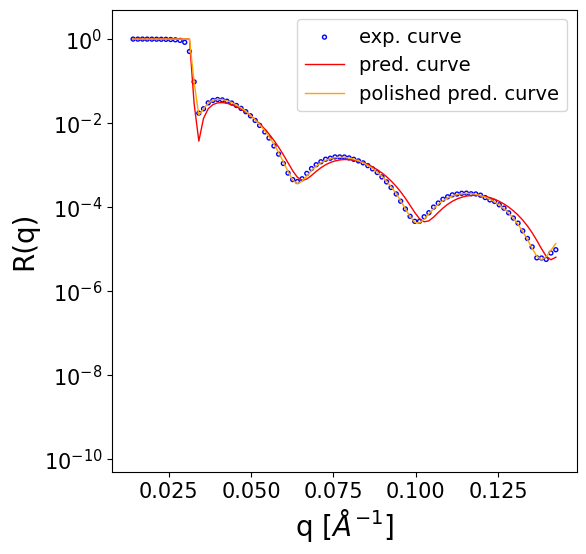

In [16]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.set_yscale('log')
ax.set_ylim(0.5e-10, 5)
ax.set_xlabel('q [$Å^{-1}$]', fontsize=20)
ax.set_ylabel('R(q)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
y_tick_locations = [10**(-2*i) for i in range(6)]
ax.yaxis.set_major_locator(plt.FixedLocator(y_tick_locations))

ax.scatter(q_exp, curve_exp, facecolors='none', edgecolors='blue', s=8, label='exp. curve')   
#ax.scatter(q_exp, curve_exp, c='b', s=2, label='exp. curve')
ax.plot(q_exp, pred_curve, c='r', lw=1, label='pred. curve')
ax.plot(q_exp, prediction_dict['polished_curve'], c='orange', lw=1, label='polished pred. curve')

ax.legend(loc='upper right', fontsize=14);

## Using alternative trainers

By default the class of the trainer object is `PointEstimatorTrainer`, whose purpose is to train the neural network as a regression problem for predicting the physical parameters based on the reflectivity curves and the prior bounds for the parameters. Other types of trainers can also be specified, for example a trainer used for encoding reflectivity curves to latent representation.

In the configuration file, the `trainer_cls` subkey of the `training` key is set to `DenoisingAETrainer`:

```{code-block} yaml
:emphasize-lines: 2

training:
  trainer_cls: DenoisingAETrainer
```

We also select an appropriate neural network for this task:

```{code-block} yaml
:emphasize-lines: 3

model:
  network:
    cls: ConvAutoencoder
    pretrained_name: null
    device: 'cuda'
    kwargs:
      in_channels: 1
      encoder_hidden_channels: [32, 64, 128, 256, 512]
      decoder_hidden_channels: [512, 256, 128, 64, 32]
      dim_latent: 64
      dim_avpool: 1
      use_batch_norm: true
      activation: 'gelu'
      decoder_in_size: 4 # num_q_points / 32
```

In [16]:
trainer = get_trainer_by_name(config_name='c_ae', load_weights=False)
print(trainer)

Model c_ae loaded. Number of parameters: 1.22 M


In [17]:
trainer.model

ConvAutoencoder(
  (encoder): ConvEncoder(
    (core): Sequential(
      (0): Sequential(
        (0): Conv1d(1, 32, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
      (1): Sequential(
        (0): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
      (2): Sequential(
        (0): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
      (3): Sequential(
        (0): Conv1d(128, 256, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none